In [1]:
# Import
%matplotlib inline
import dataset
import datetime
import numpy as np
import matplotlib.pyplot as plt
import serial
import gravity_pb2
from IPython.display import clear_output
from scipy.optimize import curve_fit, minimize_scalar

In [2]:
# Load Chirp DB

db = dataset.connect('sqlite:///../dds_params.db')
q = "SELECT * from chirp_rates ORDER BY chirp" ##WHERE chirp > 22.9 AND chirp < 23.1 
rows = db.query(q)
chirps_d = {r['chirp']: r for r in rows}
chirps = np.unique(np.array(list(chirps_d.keys())))

In [3]:
# Helpers to find appropriate chirp values from database

def get_fringe_points(start_alpha, end_alpha, num_points, dc = 0, tolerance = 0, plot=False):
    def fil(chirp_start, end_chirp, dc, tolerance):
        return end_chirp >= (chirp_start + dc - tolerance) and end_chirp <= (chirp_start + dc + tolerance)
    
    all_sets = []
    all_errors = []
    
    if dc == 0:
        dc = (end_alpha - start_alpha) / num_points
    if tolerance == 0:
        tolerance = dc/5
#     print(dc)
    for i in range(len(chirps)):
        c = chirps[i]
        if c < start_alpha or c > end_alpha:
            continue
        points = 1
        pset = []
        errors = 0
        pset.append(c)
        while points < num_points:
            j = i
            matches = dict()
            curr_chirp = pset[-1]
            while len(matches) == 0 and j < len(chirps) and chirps[j] < curr_chirp + dc + tolerance:
                if fil(curr_chirp, chirps[j], dc, tolerance):
                    matches[chirps[j]] = np.abs(curr_chirp + dc - chirps[j])
                    break
                j +=1
            if len(matches) == 0:
                break
            else:
                points+=1
                pset.append(min(matches, key=lambda x: matches[x]))
                errors += matches[min(matches, key=lambda x: matches[x])]


        if points == num_points:
            all_sets.append(pset)
            all_errors.append(errors)
            break

    if len(all_sets) == 0:
        return None
    
    all_sets = sorted(all_sets, key=lambda x: all_errors[all_sets.index(x)])
    best_set = all_sets[0]
    if plot:
        print(best_set)
        x = range(len(best_set))
        plt.scatter(x, best_set)
        plt.ylim(best_set[0], best_set[-1])
        plt.show()
    return best_set

In [4]:
# Fitting parameters for K-up

c = 299792458
k1_f = 351.720961e12 - 160e6
k2_f = 9.19263177e9 + k1_f
k1_lambda = c / k1_f
k2_lambda = c / k2_f
k1 = 2 * np.pi / k1_lambda
k2 = 2 * np.pi / k2_lambda
keff = k1 + k2

g_0 = 9.7996
def get_delta_g_from_chirp(chirp):
    return (2 * np.pi* chirp / keff * 1e6) - g_0
        

In [5]:
# Fitting Implementation
w_tolerance = 0.0001
bg_tolerance = 0.05
amp_tolerance = 0.25

chirpPeriod = lambda T: 1 / T**2

def fitExpData(chirps, pd, T):
    nominal_w = 2 * np.pi * T**2
    nominal_contrast = max(pd) - min(pd)
    nominal_background = np.average(pd)    
    
    def fitFunc(x, w, x0, b, c):
        return c/2*np.cos(w*(x - x0)) + b

    fitBounds = ([(1 - w_tolerance)*nominal_w, 0, (1 - bg_tolerance)*nominal_background, (1 - amp_tolerance)*nominal_contrast],
                 [(1 + w_tolerance)*nominal_w, 2*np.pi,(1 + bg_tolerance)*nominal_background, (1 + amp_tolerance)*nominal_contrast])
    fitParams, _ = curve_fit(fitFunc, chirps, pd, bounds=fitBounds, maxfev=2**64)
    return lambda x: fitFunc(x, *fitParams), fitParams[1]

In [48]:
# Set up serial communication
stream.close()
stream = serial.Serial('COM5', 112500, timeout=2)

In [49]:
def get_exp_params(row, raman_detuning_khz, ref_clk = 10e6):
    result = gravity_pb2.RunExperimentShot()
    chirp = row['chirp']
    if raman_detuning_khz < 0:
        chirp = -1 * chirp
    result.actual_chirp = chirp
    result.detuning = raman_detuning_khz
    result.mult = int(row['mult'])
    clock_transition = 12631770
    free_fall_time_s = .280
    mw_ramp_time_s = 0.010
    chirp_start_hz = raman_detuning_khz * 1000 + clock_transition
    chirp_stop_hz = chirp_start_hz + free_fall_time_s * 1000 * chirp * 1000
    sys_clk = row['mult'] * ref_clk
    sync_clk = sys_clk / 4
    result.mw_time_hex = int(row['t_bits'])
    result.chirp_time_hex = int(row['t_bits'])
    result.chirp_freq_hex = int(row['f_bits'])
    num_mw_steps = mw_ramp_time_s / ( result.mw_time_hex * 1/sync_clk)
    mw_delta_hz = np.abs(chirp_start_hz - clock_transition)/num_mw_steps
    freq_res = sys_clk /(2**32)
    result.clk_transition_hex = int(clock_transition / freq_res)
    result.chirp_start_hex = int(chirp_start_hz / freq_res)
    result.chirp_stop_hex = int(chirp_stop_hz / freq_res)
    result.mw_freq_hex = int(mw_delta_hz / freq_res)
    assert(result.mw_freq_hex != 0)
    return result

In [50]:
raman_detuning_khz_param = 510
shots_per_fringe = 16

#check C header for this
result_proto_size = 10

db = dataset.connect('sqlite:///3_26_final_compare.db')
table = db['recording']

def get_data_and_record(T, up, chirp, log_atom = True):
    s = stream.read(result_proto_size)
    result = gravity_pb2.Result()
    result.ParseFromString(s)
    if log_atom:
        print(result.atom_number)
    table.insert(dict(chirp=chirp, pd=result.pd_fraction, T=T, timestamp=datetime.datetime.utcnow(), direction=up))
    return result.pd_fraction

def plot_and_fit(chirps, fracs, fit):
    plt.scatter(list(map(get_delta_g_from_chirp, chirps)), fracs)
    if fit == 1:
        fit, phase = fitExpData(chirps, fracs, T)
        x_fit = np.linspace(min(chirps), max(chirps), 100)
        y_fit = fit(x_fit)
        plt.plot(list(map(get_delta_g_from_chirp, x_fit)), y_fit)
        min_chirp = minimize_scalar(fit, bounds=(min(chirps), max(chirps)), method='Bounded',
                            options={'xatol':1e-10, 'maxiter':2**64}).x
        dg = get_delta_g_from_chirp(min_chirp)
        print(g_0 + dg)
    else:
        min_chirp = 0
        clear_output(wait=True)
    plt.xlim(get_delta_g_from_chirp(min(chirps)), get_delta_g_from_chirp(max(chirps)))
    plt.show()
    return min_chirp

def experiment(exp_chirps, T, up, repeat):
    print(T)
    pd_fractions = []
    use_raman = raman_detuning_khz_param
    if not up:
        use_raman = -1 * use_raman
    
    for c in exp_chirps:
        exp_request_proto = get_exp_params(chirps_d[np.abs(c)], use_raman)
        exp_request_proto.T_ms = T
        
        # Sending the request for one shot
        stream.write(exp_request_proto.SerializeToString())
        
        # Waiting to receive the data from runing the experiment
        pd_fractions.append(get_data_and_record(T, up, c))
    
    min_chirp = plot_and_fit(curr_chirps, pd_fractions, fit=1-repeat)
    
#     avg_pd = [0]*shots_per_fringe
#     if repeat > 0:
#         request = gravity_pb2.RepeatFringes()
#         request.times = repetition
#         stream.write(request.SerializeToString())
        
#         pd_fractions = []
#         for i in range(repetition):
#             for j in range(shots_per_fringe):
#                 pd_fractions.append(get_data_and_record(T, up, False))
#                 avg_pd[j] = (pd_fractions[j] + avg_pd[j]*i)/(i+1)
#         clear_output(wait=True)
#         plt.scatter(list(map(get_delta_g_from_chirp, curr_chirps)), pd_fractions)
#         pd_fractions = []
#         plt.show()
    
#     clear_output(wait=True)
#     min_chirp = plot_and_fit(curr_chirps, avg_pd)
            
    return min_chirp
            

In [51]:
T_start = 10
T_step = 10
T_max = 70

In [52]:
def run_and_fit_expr(curr_chirps, T, up, repeat):
    run_curr_chirps = curr_chirps
    if not up:
        run_curr_chirps = list(map(lambda x: -1*x, curr_chirps))
    min_chirp = experiment(run_curr_chirps, T, up, repeat)
    return min_chirp

In [53]:
chirpPeriod = lambda T: 1 / T**2

10
7875.0
7759.0
7977.0
8435.0
7836.0
7419.0
7803.0
8188.0
7890.0
7160.0
7676.0
7810.0
8171.0
7823.0
7481.0
8240.0
9.799681057961442


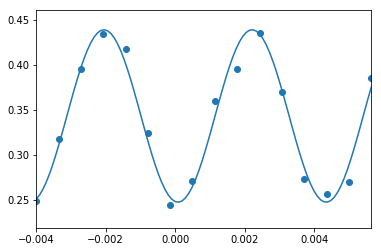

20
7963.0
7942.0
7848.0
7863.0
7962.0
8292.0
7527.0
7981.0
7498.0
7900.0
7982.0
7867.0
8173.0
8128.0
7932.0
7349.0
9.79961601120801


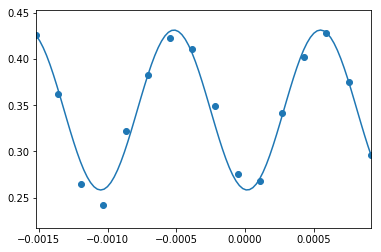

30
8400.0
7836.0
8408.0
7978.0
7865.0
8051.0
7312.0
8129.0
7537.0
7831.0
7815.0
8001.0
7631.0
7629.0
7783.0
7700.0
9.799594947929345


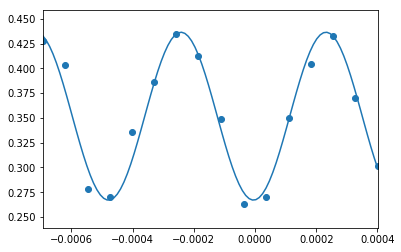

40
7891.0
8159.0
7974.0
8371.0
7629.0
7972.0
8421.0
7587.0
7661.0
8029.0
7662.0
8603.0
8265.0
7984.0
8200.0
8403.0
9.799598258033944


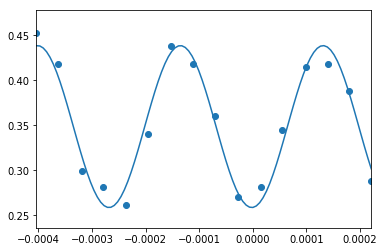

50
7725.0
8053.0
7787.0
8578.0
7963.0
8107.0
7894.0
8070.0
7855.0
8415.0
8313.0
7926.0
7292.0
8232.0
8388.0
8293.0
9.799589351262826


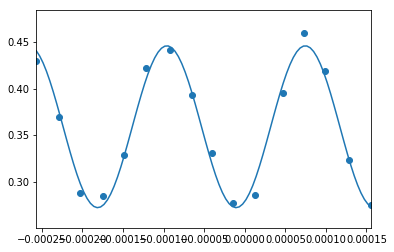

60
7762.0
8065.0
8360.0
8930.0
7661.0
7736.0
8033.0
7441.0
8125.0
8624.0
8280.0
8430.0
8204.0
8386.0
8530.0
8479.0
9.799583880115641


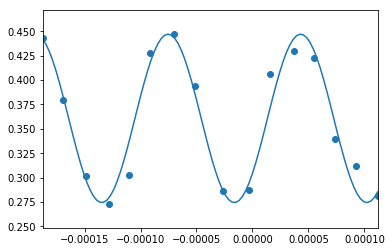

70
7671.0
8432.0
7881.0
7914.0
8279.0
8233.0
7987.0
8136.0
8567.0
7707.0
8176.0
8156.0
7383.0
7706.0
7960.0
8559.0
9.799588028024962


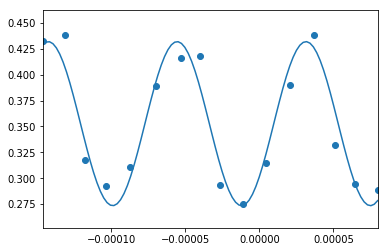

In [55]:
T = T_start
alpha = 23
while T <= T_max:
    cp = chirpPeriod(T)
    min_alpha = alpha - cp*3/2
    max_alpha = alpha + cp*3/2
    curr_chirps = get_fringe_points(alpha - cp*3/2, alpha + cp*3/2, shots_per_fringe)
    alpha = run_and_fit_expr(curr_chirps, T, up=False, repeat=0)
    T += T_step

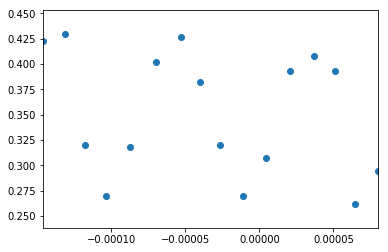

In [56]:
T = T_max
for _ in range(10):
    print(_)
    run_and_fit_expr(curr_chirps, T, up=False, repeat=1)
    
    

10
8224.0
8210.0
8213.0
7953.0
7828.0
8061.0
7821.0
7906.0
8091.0
7681.0
8307.0
8254.0
7960.0
7833.0
7959.0
7851.0
9.799463233660097


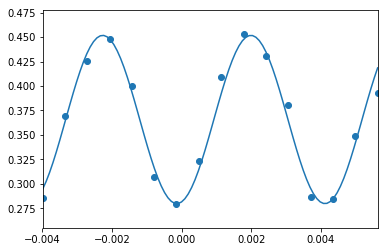

20
7486.0
7693.0
8090.0
8174.0
8225.0
7893.0
7589.0
8243.0
7879.0
8171.0
8463.0
8112.0
8200.0
8223.0
8304.0
7428.0
9.799531276952619


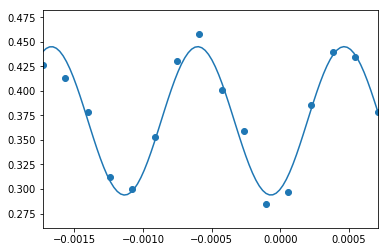

30
8056.0
8228.0
7968.0
8062.0
7977.0
7980.0
7775.0
8029.0
7604.0
8234.0
7535.0
8039.0
8115.0
8024.0
7889.0
7790.0
9.79956043620437


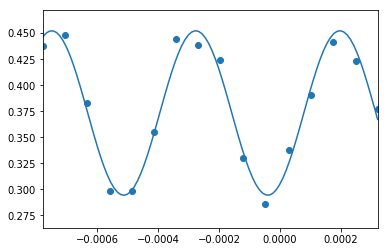

40
8168.0
7894.0
7972.0
7786.0
7701.0
8030.0
8414.0
8034.0
7536.0
8318.0
7735.0
8226.0
8051.0
8633.0
8131.0
8277.0
9.799570609396225


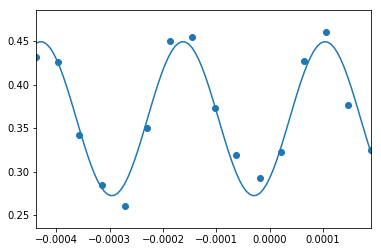

50
8401.0
7999.0
8076.0
7592.0
7819.0
7765.0
7792.0
8157.0
7676.0
8284.0
8242.0
8399.0
7788.0
8054.0
8316.0
8371.0
9.799569167611326


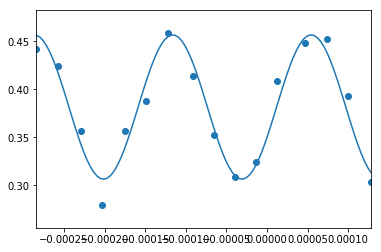

60
8744.0
8533.0
8117.0
8047.0
8426.0
8449.0
8876.0
7981.0
7844.0
8187.0
8183.0
8467.0
8391.0
8601.0
8259.0
7875.0
9.79957451337136


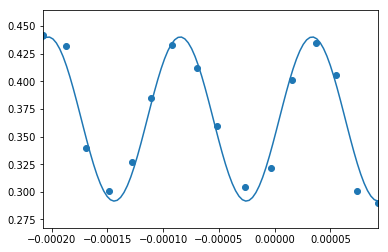

70
8511.0
9155.0
8126.0
8765.0
8256.0
8402.0
8227.0
8334.0
8714.0
8052.0
8218.0
8969.0
8146.0
7995.0
7965.0
8723.0
9.799570231470145


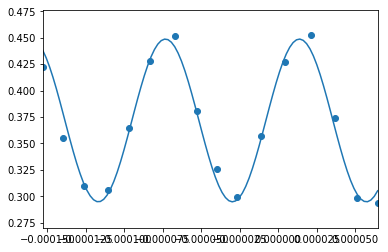

In [57]:
T = T_start
alpha = 23
while T <= T_max:
    cp = chirpPeriod(T)
    min_alpha = alpha - cp*3/2
    max_alpha = alpha + cp*3/2
    curr_chirps = get_fringe_points(alpha - cp*3/2, alpha + cp*3/2, shots_per_fringe)
    alpha = run_and_fit_expr(curr_chirps, T, up=True, repeat=0)
    T += T_step

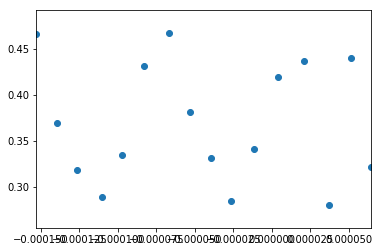

11
70
8662.0
8222.0


KeyboardInterrupt: 

In [58]:
T = T_max
for _ in range(50):
    print(_)
    run_and_fit_expr(curr_chirps, T, up=True, repeat=1)
    
    